# Анализ поведения пользователей мобильного приложения.

Изучение воронки продаж и пути пользователей к покупке, выявление количества пользователей, доходящих до покупки и проблемных этапов. <br>
Исследование результатов А/А/В-эксперимента, для выяснения целесообразности измениения шрифта.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib as mpl
import matplotlib.pyplot as plt 
import os
import datetime as dt
import scipy.stats as st
import math as mth

In [2]:
pd.options.display.max_colwidth = 150

In [3]:
pthl1 = '/datasets/logs_exp.csv'
pthw1 = 'datasets\logs_exp.csv'

In [4]:
# критический уровень статистической значимости
alpha5 = 0.05  
alpha1 = 0.01  

Зададим необходимые функции

In [5]:
# перекрёстная уникальность пользователей
def users_not_unique(dataset1, dataset2):
    users_not_uniq = np.intersect1d(dataset1, dataset2)
    return len(users_not_uniq)

In [6]:
# Создание таблиц по группам
def fil_no_dup(dataset, col, group):
    dataset = dataset[dataset[col] == group]
    return dataset

In [7]:
# Создание таблицы без указанной группы
def fil_no_dup_excl(dataset, col, group):
    dataset = dataset[dataset[col] != group]
    return dataset

In [8]:
# Уникальные пользователи в группe и их количество
def fil_no_dup_uniq(dataset, col):
    dataset = dataset[col].unique()
    users_unique = len(dataset) #['device_id_hash'].nunique()
    return dataset, users_unique

In [9]:
# Даты начала и окончания теста
def exp_timedelta(dataset, col):
    date_min = dataset[col].min()
    date_max = dataset[col].max()
    return date_min, date_max

In [10]:
# Воронка событий
def funnel_events(dataset, event, id_hash):
    dataset = dataset.groupby(event).agg({id_hash: 'count'}).sort_values(by=id_hash, ascending=False)
    column = id_hash + '_count'
    dataset.columns = [column]
    return dataset

In [11]:
# Уникальные пользователи в шаг
def funnel_events_uniq_step (dataset, event_col, event_list, id_hash):
    usr_uniq_step=[]
    for i in event_list:
        usr_uniq_step.append(dataset.loc[(dataset[event_col] == i)][id_hash].nunique())
    return usr_uniq_step

In [12]:
# Доля уникальных пользователей в шаг
def funnel_events_uniq_step_fraction(usr_uniq_step, usr_uniq_cohort):
    usr_uniq_step_frac=[]
    for i in usr_uniq_step:
        usr_uniq_step_frac.append(i / usr_uniq_cohort)
    return usr_uniq_step_frac

In [13]:
### Сложение данных двух датасетов
def funnel_events_uniq_step_combined(dataset1, dataset2):
    dataset_combined=[]
    if len(dataset1) >= len(dataset2):
        for i in range(len(dataset1)):
            dataset_combined.append(dataset1[i] + dataset2[i])
    else:
         for i in range(len(dataset2)):
            dataset_combined.append(dataset2[i] + dataset1[i])
    return dataset_combined

In [14]:
# Проверка гипотезы о равенстве долей на шаге
def checking_equality_shares(dataset1, dataset2, usr_uniq_cohort1, usr_uniq_cohort2, alpha):
    alpha_str = str(alpha)
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    if len(dataset1) >= len(dataset2):
        for i in range(len(dataset1)):
            dataset3 = dataset1
    else:
         for i in range(len(dataset2)):
            dataset3 = dataset2
            dataset2 = dataset1
    for i in range(len(dataset3)-1):
        step = logs_exp_event_name[i]
        # пропорция успехов в первой группе на шаге:
        d1 = dataset3[i] / usr_uniq_cohort1
        # пропорция успехов во второй группе на шаге:
        d2 = dataset2[i] / usr_uniq_cohort2
        # разница пропорций в датасетах
        difference = d1 - d2
        # пропорция успехов в комбинированном датасете:
        d_combined = (dataset1[i] + dataset2[i]) / (usr_uniq_cohort1 + usr_uniq_cohort2)
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(d_combined * (1 - d_combined) * (1/usr_uniq_cohort1 + 1/usr_uniq_cohort2))
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print('p-значение на шаге ' + step + ':', p_value)
        if p_value < alpha:
            print('Hа имеющихся данных, на уровне значимости ' + alpha_str + '% есть основания отвергнуть нулевую гипотезу о равенстве долей в пользу альтернативной гипотезы')
        else:
            print(
                    'Не получилось отвергнуть нулевую гипотезу, на уровне значимости ' + alpha_str + '% нет оснований считать доли разными'
                    )
    return

## Обзор данных

In [15]:
if os.path.exists(pthl1):
    logs_exp = pd.read_csv(pthl1, sep='\t')
elif os.path.exists(pthw1):
    logs_exp = pd.read_csv(pthw1, sep='\t')
else:
    print('Something is wrong')

In [16]:
display(logs_exp.head())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## Подготовка данных

In [17]:
logs_exp = logs_exp.rename(columns={'EventName':'event_name', 'DeviceIDHash':'device_id_hash', 'EventTimestamp':'event_timestamp', 'ExpId':'exp_id'})

In [18]:
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id_hash   244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [19]:
logs_exp['event_datetime'] = pd.to_datetime(logs_exp['event_timestamp'], unit='s')
logs_exp['event_date'] = pd.to_datetime(logs_exp['event_timestamp'], unit='s').dt.date

In [20]:
resume = 'Пропусков не обнаружено'
for i in logs_exp:
    if len(logs_exp[logs_exp[i].isna()]) != 0:
        resume = 'Пропуски обнаружены'
        print(i, '-', len(logs_exp[logs_exp[i].isna()])) # выводим только пропуски
print(resume)

Пропусков не обнаружено


In [21]:
logs_exp_len = len(logs_exp) # Количество строк в датасете

In [22]:
logs_exp_dup = logs_exp.duplicated().sum() # Количество дубликатов

In [23]:
logs_exp_dup_pers = round(logs_exp.duplicated().sum()/len(logs_exp)*100, 2).astype('str') # Процент дубликатов в датасете

In [24]:
msg = 'Процент дубликатов в датасете - ' + logs_exp_dup_pers + '%'

In [25]:
logs_exp_mea = round(logs_exp.groupby('device_id_hash').agg({'event_name': 'count'}).mean()) # Среднее количество событий на одного пользователя

In [26]:
logs_exp_id_hash_count = logs_exp['device_id_hash'].nunique()

In [27]:
print('Количество уникальных пользователей -', logs_exp_id_hash_count)
print('Количество строк в датасете -', logs_exp_len)
print('Количество дубликатов -', logs_exp_dup)
print(msg)
print('Количество пользователей в логе -', logs_exp['device_id_hash'].nunique())
print('Среднее количество событий на одного пользователя -', logs_exp_mea[0])
print('Начало периода -', logs_exp['event_datetime'].min())
print('Окончание периода -', logs_exp['event_datetime'].max())

Количество уникальных пользователей - 7551
Количество строк в датасете - 244126
Количество дубликатов - 413
Процент дубликатов в датасете - 0.17%
Количество пользователей в логе - 7551
Среднее количество событий на одного пользователя - 32.0
Начало периода - 2019-07-25 04:43:36
Окончание периода - 2019-08-07 21:15:17


Дубликаты имеются, удалим их.

In [28]:
logs_exp = logs_exp.drop_duplicates()

In [29]:
logs_exp = logs_exp.reset_index(drop=True)

## Проверка данных

In [30]:
logs_exp_len = len(logs_exp) # Количество строк в датасете

In [31]:
logs_exp_dup = logs_exp.duplicated().sum() # Количество дубликатов

In [32]:
logs_exp_dup_pers = round(logs_exp.duplicated().sum()/len(logs_exp)*100, 2).astype('str') # Процент дубликатов в датасете

In [33]:
msg = 'Процент дубликатов в датасете - ' + logs_exp_dup_pers + '%'

In [34]:
logs_exp_mea = round(logs_exp.groupby('device_id_hash').agg({'event_name': 'count'}).mean()) # Среднее количество событий на одного пользователя

In [35]:
log_exp_usr_uniq = logs_exp['device_id_hash'].nunique()

In [36]:
print('Количество строк в датасете -', logs_exp_len)
print('Количество дубликатов -', logs_exp_dup)
print(msg)
print('Количество пользователей в логе -', log_exp_usr_uniq)
print('Среднее количество событий на одного пользователя -', logs_exp_mea[0])
print('Начало периода -', logs_exp['event_datetime'].min())
print('Окончание периода -', logs_exp['event_datetime'].max())

Количество строк в датасете - 243713
Количество дубликатов - 0
Процент дубликатов в датасете - 0.0%
Количество пользователей в логе - 7551
Среднее количество событий на одного пользователя - 32.0
Начало периода - 2019-07-25 04:43:36
Окончание периода - 2019-08-07 21:15:17


In [39]:
logs_exp_device_id_hash_events = logs_exp.groupby('device_id_hash').agg({'event_name': 'count'}).reset_index()

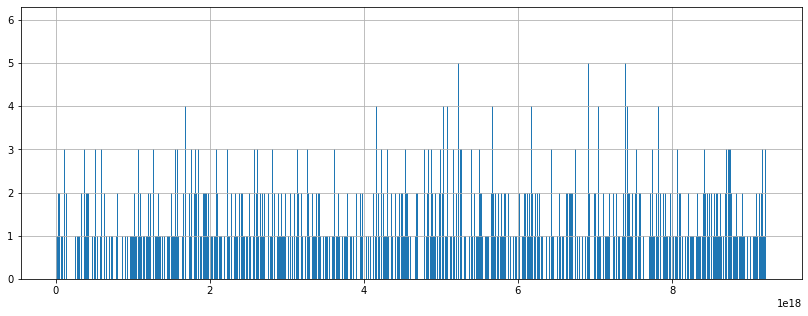

In [44]:
logs_exp_device_id_hash_events['device_id_hash'].hist(bins=7551, figsize=(14, 5));

In [45]:
logs_exp_date = logs_exp.groupby('event_date').agg({'event_name': 'count'})#.reset_index
logs_exp_date.columns=['events']
#print(logs_exp_date)

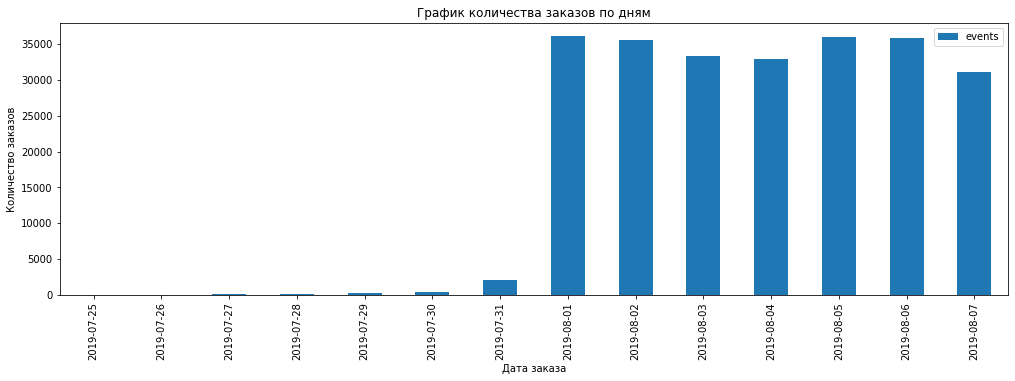

In [46]:
logs_exp_date.plot(y='events', kind='bar', figsize=(17,5), 
                   title='График количества заказов по дням',
                   xlabel='Дата заказа',
                   ylabel='Количество заказов');

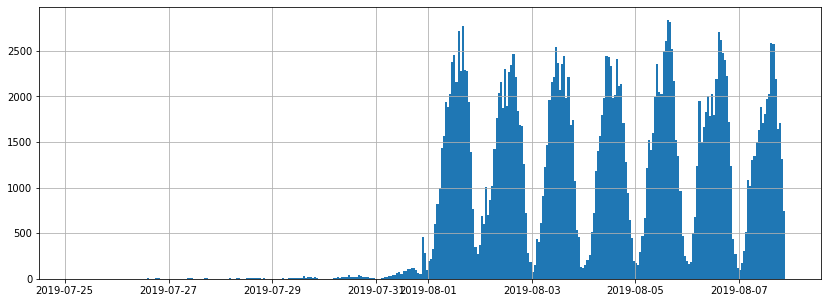

In [47]:
logs_exp['event_datetime'].hist(bins=14*24, figsize=(14, 5));

Данных с 25.07.19 по 31.07.19 ничтожно мало по сравнению с первой неделей августа. Ими придётся пожертвовать.

In [48]:
logs_exp_filtered = logs_exp[(logs_exp['event_datetime'] >= "2019-08-01")]

In [49]:
print('Потери в данных составят', round((1-logs_exp_filtered.shape[0]/logs_exp.shape[0])*100, 2), 'процента.')

Потери в данных составят 1.16 процента.


In [62]:
logs_exp_del = logs_exp[(logs_exp['event_datetime'] <= "2019-07-31")]

In [63]:
log_exp_del_usr_count = logs_exp_del['device_id_hash'].nunique()

In [64]:
msg = 'Возможные потери составят - ' + str(round(log_exp_del_usr_count/log_exp_usr_uniq*100, 2)) + '%.'

In [65]:
print('Количество утрачиваемых пользователей в логе -', log_exp_del_usr_count)
print(msg)

Количество утрачиваемых пользователей в логе - 555
Возможные потери составят - 7.35%.


Посмотрим, сколько пользователей из этого диапазона дат попали в группы.

In [66]:
logs_exp_fil_no_dup = logs_exp_filtered.drop_duplicates()

In [67]:
log_exp_del_usr_uniq = logs_exp_del['device_id_hash'].unique()

In [68]:
log_exp_del_usr_uniq = np.unique(log_exp_del_usr_uniq)

In [69]:
logs_exp_filtered_uniq = logs_exp_filtered['device_id_hash'].unique()

In [70]:
logs_exp_filtered_uniq = np.unique(logs_exp_filtered_uniq)

In [71]:
log_exp_del_usr_uniq_end = []
for i in log_exp_del_usr_uniq:
    if i not in logs_exp_filtered_uniq:
        log_exp_del_usr_uniq_end.append(i)

In [72]:
print('Количество утраченых пользователей в логе -', len(log_exp_del_usr_uniq_end))
print(msg)

Количество утраченых пользователей в логе - 11
Возможные потери составят - 7.35%.


In [73]:
logs_exp_filt_id_hash_count = logs_exp_filtered['device_id_hash'].nunique()

In [74]:
msg = 'Потери составили - ' + str(round((1-logs_exp_filt_id_hash_count/logs_exp_id_hash_count)*100, 2)) + '%.'

In [75]:
print('Количество утраченых пользователей в логе -', logs_exp_id_hash_count - logs_exp_filt_id_hash_count)
print(msg)

Количество утраченых пользователей в логе - 17
Потери составили - 0.23%.


In [76]:
logs_exp_fil_date = logs_exp_filtered.groupby('event_date').agg({'event_name': 'count'})#.reset_index
logs_exp_fil_date.columns=['events']

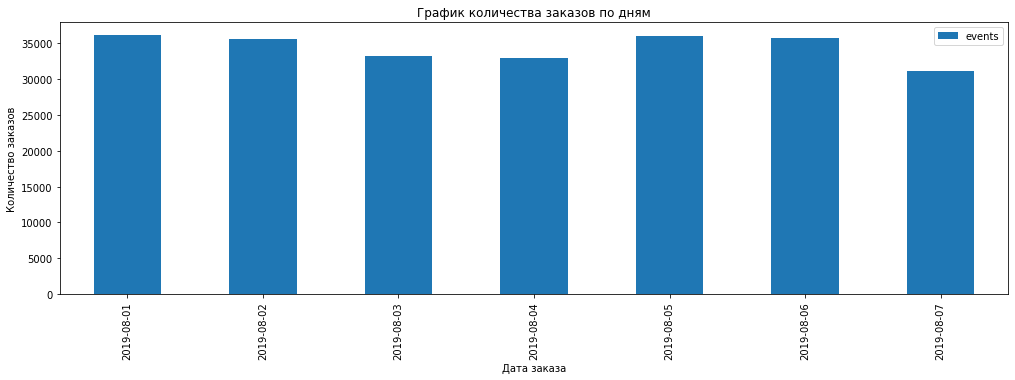

In [77]:
logs_exp_fil_date.plot(y='events', kind='bar', figsize=(17,5), 
                   title='График количества заказов по дням',
                   xlabel='Дата заказа',
                   ylabel='Количество заказов');

In [79]:
plt.xlabel='Дата заказа'

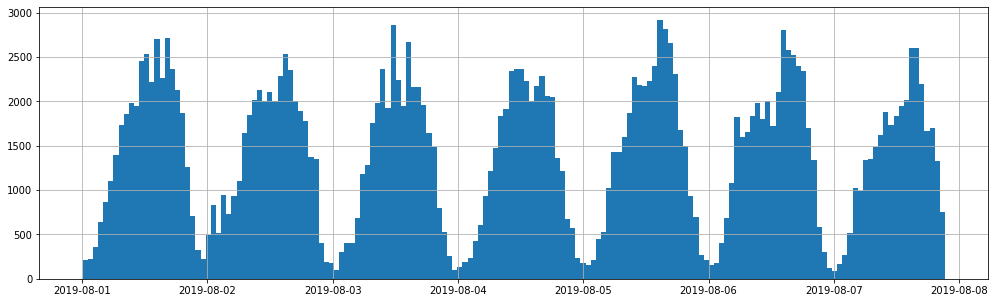

In [82]:
logs_exp_filtered['event_datetime'].hist(bins=7*24, figsize=(17, 5));

Теперь картина ровнее.

Все ли группы в наличии?

In [83]:
logs_exp_fil_no_dup['exp_id'].unique()

array([246, 247, 248])

Eсть пользователи из всех трёх экспериментальных групп.

## Изучение воронки событий

In [84]:
logs_exp_id_hash_uniq_step = logs_exp_fil_no_dup.groupby(['event_name', 'device_id_hash', 'exp_id']).agg({'event_timestamp': 'count'}).sort_values(by='device_id_hash', ascending=False).reset_index()

In [85]:
logs_exp_id_hash_count = logs_exp_id_hash_uniq_step.groupby('event_name').agg({'device_id_hash': 'count'}).sort_values(by='device_id_hash', ascending=False)
logs_exp_id_hash_count.columns = ['user_count']
logs_exp_event_name = logs_exp_id_hash_count.index

In [86]:
print(logs_exp_event_name)
display(logs_exp_id_hash_count)

Index(['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear',
       'PaymentScreenSuccessful', 'Tutorial'],
      dtype='object', name='event_name')


,user_count
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


Предположительная последовательность событий:<br>
MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful

In [90]:
logs_exp_fil_no_dup_funn = logs_exp_fil_no_dup.groupby('event_name').agg({'device_id_hash':'nunique'}).sort_values(by='device_id_hash', ascending=False).reset_index()
logs_exp_fil_no_dup_funn['fraction'] = logs_exp_fil_no_dup_funn['device_id_hash']/logs_exp_filt_id_hash_count

In [91]:
logs_exp_fil_no_dup_funn

,event_name,device_id_hash,fraction
0,MainScreenAppear,7419,0.984736
1,OffersScreenAppear,4593,0.609636
2,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737
4,Tutorial,840,0.111495


Событие "Tutorial" может происходить параллельно с любым событием, кроме "MainScreenAppear".

In [92]:
for i in range(len(logs_exp_id_hash_count.head(4))-1):
    i0 = logs_exp_id_hash_count['user_count'][i]
    i1 = logs_exp_id_hash_count['user_count'][i+1]
    conv = round(i1/i0*100, 2).astype('str') 
    print('Конверсия на шаге ' + logs_exp_id_hash_count.index[i] + ' -> ' + logs_exp_id_hash_count.index[i+1] + ' - ' + conv + '%')

Конверсия на шаге MainScreenAppear -> OffersScreenAppear - 61.91%
Конверсия на шаге OffersScreenAppear -> CartScreenAppear - 81.3%
Конверсия на шаге CartScreenAppear -> PaymentScreenSuccessful - 94.78%


Наибольшее количество пользователей теряется на первом шаге

In [93]:
print('Доля пользователей доходящих от первого события до оплаты - ' + 
        round(logs_exp_id_hash_count['user_count'][-2]/
              logs_exp_id_hash_count['user_count'][0]*100, 2).astype('str') +
      '%')

Доля пользователей доходящих от первого события до оплаты - 47.7%


## Изучение результатов эксперимента

### Количество уникальных пользователей в группах

Создадим таблицы по группам.

In [94]:
logs_exp_fil_no_dup_246 = fil_no_dup(logs_exp_fil_no_dup, 'exp_id', 246)
logs_exp_fil_no_dup_247 = fil_no_dup(logs_exp_fil_no_dup, 'exp_id', 247)
logs_exp_fil_no_dup_248 = fil_no_dup(logs_exp_fil_no_dup, 'exp_id', 248)

In [95]:
logs_exp_fil_no_dup_unique_246, logs_exp_fil_no_dup_uniq_count_246 = fil_no_dup_uniq(logs_exp_fil_no_dup_246, 'device_id_hash')
logs_exp_fil_no_dup_unique_247, logs_exp_fil_no_dup_uniq_count_247 = fil_no_dup_uniq(logs_exp_fil_no_dup_247, 'device_id_hash')
logs_exp_fil_no_dup_unique_248, logs_exp_fil_no_dup_uniq_count_248 = fil_no_dup_uniq(logs_exp_fil_no_dup_248, 'device_id_hash')

In [96]:
print('Количество уникальных пользователей в группах:')
print(logs_exp_fil_no_dup_uniq_count_246)
print(logs_exp_fil_no_dup_uniq_count_247)
print(logs_exp_fil_no_dup_uniq_count_248)

Количество уникальных пользователей в группах:
2484
2513
2537


Проверим перекрёстную уникальность пользователей

In [97]:
print(users_not_unique(logs_exp_fil_no_dup_unique_246, logs_exp_fil_no_dup_unique_247))
print(users_not_unique(logs_exp_fil_no_dup_unique_247, logs_exp_fil_no_dup_unique_248))
print(users_not_unique(logs_exp_fil_no_dup_unique_246, logs_exp_fil_no_dup_unique_248))

0
0
0


Пользователи каждой группы уникальны по отношению к любой другой группе.

In [98]:
date_min_246, date_max_246 = exp_timedelta(logs_exp_fil_no_dup_246, 'event_date')
date_min_247, date_max_247 = exp_timedelta(logs_exp_fil_no_dup_247, 'event_date')
date_min_248, date_max_248 = exp_timedelta(logs_exp_fil_no_dup_248, 'event_date')

In [99]:
print('Начало теста группы 246:', date_min_246, ', Окончание:', date_max_246)
print('Начало теста группы 247:', date_min_247, ', Окончание:', date_max_247)
print('Начало теста группы 248:', date_min_248, ', Окончание:', date_max_248)

Начало теста группы 246: 2019-08-01 , Окончание: 2019-08-07
Начало теста группы 247: 2019-08-01 , Окончание: 2019-08-07
Начало теста группы 248: 2019-08-01 , Окончание: 2019-08-07


Тест по всем трём группам начат и закончен одновременно.

#### Cтатистическая разница между выборками

Взглянем на воронки событий по группам в разрезе уникальных пользователей

In [100]:
logs_exp_fil_no_dup_246 = fil_no_dup(logs_exp_id_hash_uniq_step, 'exp_id', 246)
logs_exp_fil_no_dup_247 = fil_no_dup(logs_exp_id_hash_uniq_step, 'exp_id', 247)
logs_exp_fil_no_dup_248 = fil_no_dup(logs_exp_id_hash_uniq_step, 'exp_id', 248)

In [101]:
logs_exp_event_name_count_246 = funnel_events(logs_exp_fil_no_dup_246, 'event_name', 'device_id_hash')
logs_exp_event_name_count_247 = funnel_events(logs_exp_fil_no_dup_247, 'event_name', 'device_id_hash')
logs_exp_event_name_count_248 = funnel_events(logs_exp_fil_no_dup_248, 'event_name', 'device_id_hash')

In [102]:
display(logs_exp_event_name_count_246)
display(logs_exp_event_name_count_247)
display(logs_exp_event_name_count_248)

,device_id_hash_count
event_name,
MainScreenAppear,2450
OffersScreenAppear,1542
CartScreenAppear,1266
PaymentScreenSuccessful,1200
Tutorial,278


,device_id_hash_count
event_name,
MainScreenAppear,2476
OffersScreenAppear,1520
CartScreenAppear,1238
PaymentScreenSuccessful,1158
Tutorial,283


,device_id_hash_count
event_name,
MainScreenAppear,2493
OffersScreenAppear,1531
CartScreenAppear,1230
PaymentScreenSuccessful,1181
Tutorial,279


Взглянем на воронку событий по объединённым группам 246 и 247

In [103]:
logs_exp_fil_no_dup_246_247 = fil_no_dup_excl(logs_exp_id_hash_uniq_step, 'exp_id', 248)

In [104]:
logs_exp_event_name_count_246_247 = funnel_events(logs_exp_fil_no_dup_246_247, 'event_name', 'device_id_hash')

In [105]:
logs_exp_event_name_count_246_247

,device_id_hash_count
event_name,
MainScreenAppear,4926
OffersScreenAppear,3062
CartScreenAppear,2504
PaymentScreenSuccessful,2358
Tutorial,561


In [106]:
usr_uniq_step_246 = funnel_events_uniq_step(logs_exp_fil_no_dup_246, 'event_name', logs_exp_event_name, 'device_id_hash')
usr_uniq_step_247 = funnel_events_uniq_step(logs_exp_fil_no_dup_247, 'event_name', logs_exp_event_name, 'device_id_hash')
usr_uniq_step_248 = funnel_events_uniq_step(logs_exp_fil_no_dup_248, 'event_name', logs_exp_event_name, 'device_id_hash')

In [107]:
usr_uniq_step_246_247 = funnel_events_uniq_step(logs_exp_fil_no_dup_246_247, 'event_name', logs_exp_event_name, 'device_id_hash')

In [108]:
logs_exp_fil_no_dup_unique_246_247, logs_exp_fil_no_dup_uniq_count_246_247 = fil_no_dup_uniq(logs_exp_fil_no_dup_246_247, 'device_id_hash')

#### Проверка гипотезы о равенстве долей

##### Проверка гипотезы о равенстве долей на каждом шаге в экспериментах 246 и 247

Гипотезы:
* нулевая: доли пользователей на каждом шаге в экспериментах 246 и 247 равны;
* альтернативная: доли пользователей на каждом шаге в экспериментах 246 и 247 различны.

In [109]:
checking_equality_shares(usr_uniq_step_246, usr_uniq_step_247, logs_exp_fil_no_dup_uniq_count_246, logs_exp_fil_no_dup_uniq_count_247, alpha1)

p-значение на шаге MainScreenAppear: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.01% нет оснований считать доли разными
p-значение на шаге OffersScreenAppear: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.01% нет оснований считать доли разными
p-значение на шаге CartScreenAppear: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.01% нет оснований считать доли разными
p-значение на шаге PaymentScreenSuccessful: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.01% нет оснований считать доли разными


In [110]:
checking_equality_shares(usr_uniq_step_246, usr_uniq_step_247, logs_exp_fil_no_dup_uniq_count_246, logs_exp_fil_no_dup_uniq_count_247, alpha5)

p-значение на шаге MainScreenAppear: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.05% нет оснований считать доли разными
p-значение на шаге OffersScreenAppear: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.05% нет оснований считать доли разными
p-значение на шаге CartScreenAppear: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.05% нет оснований считать доли разными
p-значение на шаге PaymentScreenSuccessful: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.05% нет оснований считать доли разными


In [111]:
checking_equality_shares(usr_uniq_step_246, usr_uniq_step_247, logs_exp_fil_no_dup_uniq_count_246, logs_exp_fil_no_dup_uniq_count_247, 0.1)

p-значение на шаге MainScreenAppear: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.1% нет оснований считать доли разными
p-значение на шаге OffersScreenAppear: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.1% нет оснований считать доли разными
p-значение на шаге CartScreenAppear: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.1% нет оснований считать доли разными
p-значение на шаге PaymentScreenSuccessful: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.1% нет оснований считать доли разными


##### Проверка гипотезы о равенстве долей на каждом шаге в экспериментах 246 и 247

Гипотезы:
* нулевая: доли пользователей на каждом шаге в экспериментах 246 и 248 равны;
* альтернативная: доли пользователей на каждом шаге в экспериментах 246 и 248 различны.

In [112]:
checking_equality_shares(usr_uniq_step_246, usr_uniq_step_248, logs_exp_fil_no_dup_uniq_count_246, logs_exp_fil_no_dup_uniq_count_248, alpha1)

p-значение на шаге MainScreenAppear: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.01% нет оснований считать доли разными
p-значение на шаге OffersScreenAppear: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.01% нет оснований считать доли разными
p-значение на шаге CartScreenAppear: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.01% нет оснований считать доли разными
p-значение на шаге PaymentScreenSuccessful: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.01% нет оснований считать доли разными


In [113]:
checking_equality_shares(usr_uniq_step_246, usr_uniq_step_248, logs_exp_fil_no_dup_uniq_count_246, logs_exp_fil_no_dup_uniq_count_248, alpha5)

p-значение на шаге MainScreenAppear: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.05% нет оснований считать доли разными
p-значение на шаге OffersScreenAppear: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.05% нет оснований считать доли разными
p-значение на шаге CartScreenAppear: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.05% нет оснований считать доли разными
p-значение на шаге PaymentScreenSuccessful: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.05% нет оснований считать доли разными


In [114]:
checking_equality_shares(usr_uniq_step_246, usr_uniq_step_248, logs_exp_fil_no_dup_uniq_count_246, logs_exp_fil_no_dup_uniq_count_248, 0.1)

p-значение на шаге MainScreenAppear: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.1% нет оснований считать доли разными
p-значение на шаге OffersScreenAppear: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.1% нет оснований считать доли разными
p-значение на шаге CartScreenAppear: 0.07842923237520116
Hа имеющихся данных, на уровне значимости 0.1% есть основания отвергнуть нулевую гипотезу о равенстве долей в пользу альтернативной гипотезы
p-значение на шаге PaymentScreenSuccessful: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.1% нет оснований считать доли разными


##### Проверка гипотезы о равенстве долей на каждом шаге в экспериментах 247 и 248

Гипотезы:
* нулевая: доли пользователей на каждом шаге в экспериментах 248 и 247 равны;
* альтернативная: доли пользователей на каждом шаге в экспериментах 248 и 247 различны.

In [115]:
checking_equality_shares(usr_uniq_step_247, usr_uniq_step_248, logs_exp_fil_no_dup_uniq_count_247, logs_exp_fil_no_dup_uniq_count_248, alpha1)

p-значение на шаге MainScreenAppear: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.01% нет оснований считать доли разными
p-значение на шаге OffersScreenAppear: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.01% нет оснований считать доли разными
p-значение на шаге CartScreenAppear: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.01% нет оснований считать доли разными
p-значение на шаге PaymentScreenSuccessful: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.01% нет оснований считать доли разными


In [116]:
checking_equality_shares(usr_uniq_step_247, usr_uniq_step_248, logs_exp_fil_no_dup_uniq_count_247, logs_exp_fil_no_dup_uniq_count_248, alpha5)

p-значение на шаге MainScreenAppear: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.05% нет оснований считать доли разными
p-значение на шаге OffersScreenAppear: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.05% нет оснований считать доли разными
p-значение на шаге CartScreenAppear: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.05% нет оснований считать доли разными
p-значение на шаге PaymentScreenSuccessful: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.05% нет оснований считать доли разными


In [117]:
checking_equality_shares(usr_uniq_step_247, usr_uniq_step_248, logs_exp_fil_no_dup_uniq_count_247, logs_exp_fil_no_dup_uniq_count_248, 0.1)

p-значение на шаге MainScreenAppear: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.1% нет оснований считать доли разными
p-значение на шаге OffersScreenAppear: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.1% нет оснований считать доли разными
p-значение на шаге CartScreenAppear: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.1% нет оснований считать доли разными
p-значение на шаге PaymentScreenSuccessful: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.1% нет оснований считать доли разными


##### Проверка гипотезы о равенстве долей на каждом шаге в экспериментах объединённой группы и 248

Гипотезы:
* нулевая: доли пользователей на каждом шаге в экспериментах объединённой группы и группы 248 равны;
* альтернативная: доли пользователей на каждом шаге в экспериментах объединённой группы и группы 248 различны.

In [118]:
checking_equality_shares(usr_uniq_step_246_247, usr_uniq_step_248, logs_exp_fil_no_dup_uniq_count_246_247, logs_exp_fil_no_dup_uniq_count_248, alpha1)

p-значение на шаге MainScreenAppear: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.01% нет оснований считать доли разными
p-значение на шаге OffersScreenAppear: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.01% нет оснований считать доли разными
p-значение на шаге CartScreenAppear: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.01% нет оснований считать доли разными
p-значение на шаге PaymentScreenSuccessful: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.01% нет оснований считать доли разными


In [119]:
checking_equality_shares(usr_uniq_step_246_247, usr_uniq_step_248, logs_exp_fil_no_dup_uniq_count_246_247, logs_exp_fil_no_dup_uniq_count_248, alpha5)

p-значение на шаге MainScreenAppear: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.05% нет оснований считать доли разными
p-значение на шаге OffersScreenAppear: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.05% нет оснований считать доли разными
p-значение на шаге CartScreenAppear: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.05% нет оснований считать доли разными
p-значение на шаге PaymentScreenSuccessful: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.05% нет оснований считать доли разными


In [120]:
checking_equality_shares(usr_uniq_step_246_247, usr_uniq_step_248, logs_exp_fil_no_dup_uniq_count_246_247, logs_exp_fil_no_dup_uniq_count_248, 0.1)

p-значение на шаге MainScreenAppear: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.1% нет оснований считать доли разными
p-значение на шаге OffersScreenAppear: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.1% нет оснований считать доли разными
p-значение на шаге CartScreenAppear: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.1% нет оснований считать доли разными
p-значение на шаге PaymentScreenSuccessful: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, на уровне значимости 0.1% нет оснований считать доли разными


При увеличении количества сравнений, вероятность получить различие между группами возраситает, поэтому уровень статистической значимости стоит понизить. В исследуемых данных мы производим 4 парных сравнения, вероятность получения, результата, позволяющего отвергнуть нулевую гипотезу, возрастает в 4 раза. Т.о., уровень статистической значимости стоит понизить в 4 раза, до 0.0125%.

##### Вывод

При уровнях статистической значимости от 0.01% до 0.05%  доли пользователей на каждом шаге в экспериментах можно считать равными.

Разбиение на группы АА теста работает корректно.

## Результат

Во время проведения исследования были обработаны пропуски в данных, удалены явные дубликаты и отброшены дни с недостаточным количеством данных, определены истинные сроки проведения эксперимента.<br>
Количество утраченых пользователей в логе - 17. Потери составили - 0.23%.<br>
Общие потери в данных после фильтрации составили 1.16%.<br>
Определена воронка событий: MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful. <br>
Определён шаг c максимальной потерей пользователей: MainScreenAppear -> OffersScreenAppear - 38.09%.<br>
Определена доля пользователей доходящих от первого события до оплаты - 47.7%

## Вывод

Разбиение на группы АА теста работает корректно.<br>
Уровень значимости следует принять равным 0,01%.<br>
Доли пользователей на каждом шаге в экспериментах всех групп равны.